In [1]:
import numpy as np 
import pandas as pd 
import random
import cv2 as cv
import os, glob
import matplotlib.pyplot as plt
%matplotlib inline

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image

Using TensorFlow backend.


In [2]:
data = pd.read_csv('../input/train_info.csv')
train_files = [f for f in glob.glob("../input/train_2/*")]

In [3]:
genre = set(data["genre"])
style = set(data["style"])

genre_to_int = dict((g, i) for i, g in enumerate(genre))
style_to_int = dict((s, i) for i, s in enumerate(style))

int_to_genre = dict((i, g) for i, g in enumerate(genre))
int_to_style = dict((i, s) for i, s in enumerate(style))

data['genre_idx'] = data["genre"].apply(lambda x: genre_to_int[x])
data['style_idx'] = data["style"].apply(lambda x: style_to_int[x])

data.head(3)

,filename,artist,title,style,genre,date,genre_idx,style_idx
0,102257.jpg,5b39c876740bfc1cfaf544721c43cac3,Uriel,Color Field Painting,abstract,1955.0,18,117
1,75232.jpg,5b39c876740bfc1cfaf544721c43cac3,Vir Heroicus Sublimis,Color Field Painting,abstract,1950.0,18,117
2,29855.jpg,96e5bc98488ed589b9bf17ad9fd09371,Night March of a Hundred Demons (left half),Yamato-e,mythological painting,NaN,19,79


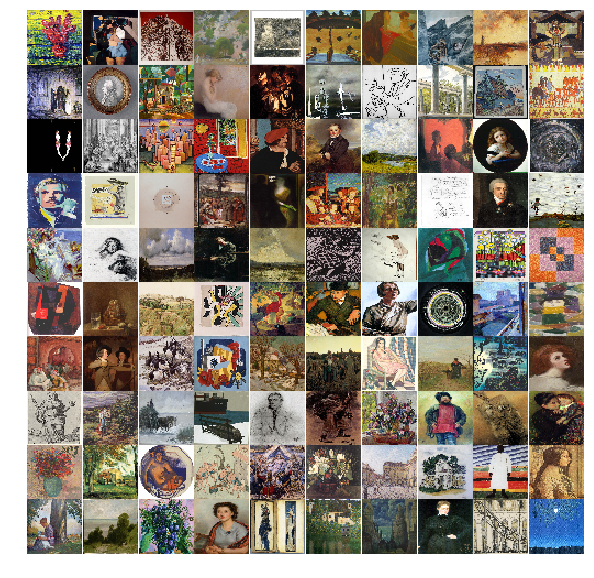

In [ ]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for i, l in enumerate(train_files[:100]):
    img = cv.imread(l)
    img = cv.resize(img, (50, 50)) 
    plt.subplot(10, 10, i+1)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.axis('off')

In [ ]:
X_train = []
Y_style = []
Y_genre = []

for path in train_files:
    file = path.split('/')[3]
    img = cv.imread(path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    X_train.append(img)
    genre = data.loc[data["filename"] == file].values[0][6]
    style = data.loc[data["filename"] == file].values[0][7]
    Y_style.append(style)
    Y_genre.append(genre)

In [ ]:
size = 5
for i in range(size):
    idxs = np.random.choice(len(genre), size, replace=False)
    for j, idx in enumerate(idxs):
        plt_idx = i * size + j + 1
        plt.subplot(size, size, plt_idx)
        plt.imshow(X_train[idx])
        plt.title(int_to_genre[Y_genre[idx]])
        plt.axis("off")
plt.show()

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x_style = Dense(512, activation='relu')(x)
x_genre = Dense(512, activation='relu')(x)
pred_style = Dense(200, activation='softmax')(x_style)
pred_genre = Dense(200, activation='softmax')(x_genre)

model = Model(inputs=base_model.input, outputs=[pred_style, pred_genre])
model.compile(optimizer='adam', loss=['categorical_crossentropy', 'categorical_crossentropy'])

In [ ]:
model.fit(X_train, [Y_style, Y_genre], verbose = True, shuffle="batch", epochs = 5, batch_size=32)